# Compositional analysis of the COPD-IAV scRNA dataset using scCoda (pertpy):
- Developed by: Christian Eger
- Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg
- Created on: 231214
- Last modified: 231214<br>
6 Patients with and 6 without chronic obstructive pulmonary disease (COPD).
Epithelial cells extracted with a lung wash and exposed to IAV (Control and IAV n=3 for both COPD and healthy patients)
--> scRNA-seq and cell types annotated

### Preparation of the mamba environment

Created mamba environment in /Users/egerc/miniforge3/envs/pertpy-env  
mamba create -n pertpy-env python=3.10  
mamba activate pertpy-env<br>  
Manual git installation of pertpy necessary due to Apple silicon  
git clone https://github.com/theislab/pertpy.git  
cd pertpy  
pip install .  

In [1]:
import warnings

import pandas as pd

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import scanpy as sc
import numpy as np
#import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import altair as alt
import pertpy as pt


In [2]:
sc.logging.print_versions()

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
adjustText                  0.8
aiohttp                     3.9.1
aiosignal                   1.3.1
altair                      5.2.0
annotated_types             0.6.0
anyio                       NA
appnope                     0.1.3
arrow                       1.3.0
arviz                       0.16.1
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
backoff                     2.2.1
bs4                         4.12.2
certifi                     2023.11.17
cffi                        1.16.0
chardet                     5.2.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
custom_inherit              2.4.1
cycle

### Preparation of AnnData object

1. Creation of adata from h5ad file
2. Subsetting the adata dataframe to the cell_compartment of choice

In [3]:
adata = sc.read_h5ad("Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'


In [4]:
adata.obs.cell_compartment.unique().tolist()
#prints a list of possible cell_compartments to subset adata to


['Ciliated',
 'Club',
 'Deuterosomal',
 'Unknown',
 'Goblet',
 'Basal',
 'Ionocyte',
 'Secretory',
 'SupraB',
 'Epi']

In [5]:

adata_cell_compartment = adata[adata.obs['cell_compartment'].isin(['Secretory'])]
adata_cell_compartment


View of AnnData object with n_obs × n_vars = 3002 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [6]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata_cell_compartment,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_states",
    sample_identifier="batch",
    covariate_obs=["infection", "disease", "group"],
)
# https://pertpy.readthedocs.io/en/latest/usage/tools/pertpy.tools.Sccoda.html#pertpy.tools.Sccoda.load
sccoda_data

MuData object with n_obs × n_vars = 3026 × 27209
  2 modalities
    rna:	3002 x 27208
      obs:	'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'scCODA_sample_id'
      var:	'mt', 'ribo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
    coda:	24 x 1
      obs:	'infection', 'disease', 'group', 'batch'
      var:	'n_cells'

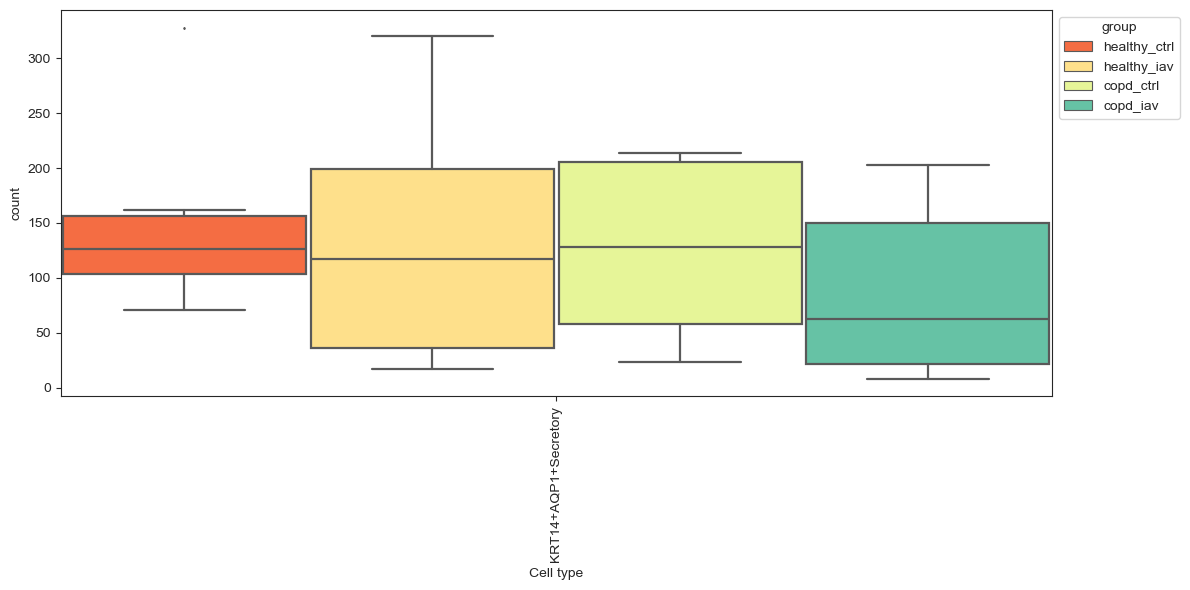

In [7]:
pt.pl.coda.boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="group",
    y_scale="count",
    plot_facets=False,
    figsize=(12, 6),
    dpi=100,
    cmap="Spectral",
    add_dots=False,
    show_legend="True",
    level_order=[],
    args_swarmplot={"palette": ["blue"]},
    args_boxplot={"order": None,
                  "orient": "v",
                  "color": "green",
                  "saturation": 1,
                  "dodge": True,
                  "width": 1,
                  "linewidth": 1.6}
)
#Parameters: https://pertpy.readthedocs.io/en/latest/usage/tools/pertpy.tools.Sccoda.html#pertpy.tools.Sccoda.plot_boxplots

plt.show()


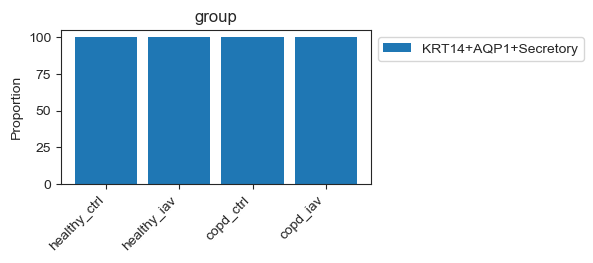

In [8]:
pt.pl.coda.stacked_barplot(
    sccoda_data, 
    modality_key="coda",
    feature_name="group", 
    figsize=(4, 2)
)
plt.show()

### Data modelling using ScCoda

Function sccoda.run_nuts() broken at the moment
https://github.com/theislab/pertpy/issues/454
Downgrading Jax didn't solve the issue for me.

--> solution: completely new environment, install jax=0.4.20 prior to installing pertpy

In [9]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="group",
    reference_cell_type="automatic",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

Automatic reference selection! Reference cell type set to KRT14+AQP1+Secretory

AssertionError: size of plate should be positive

In [ ]:
sccoda_data["coda"].varm["effect_df_group[T.healthy_iav]"]

,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Cell Type,,,,,,,
KRT14+Goblet,0.000000,-1.385,0.011,0.446,0.8118,197.489504,-0.067572
KRT17+Goblet,0.000000,-0.600,0.452,0.161,0.3296,165.618250,-0.067572
MUC5B+Goblet,0.000000,-1.131,0.120,0.357,0.5739,191.461250,-0.067572
RARRES1+lip_Goblet,0.000000,-0.159,1.389,0.461,0.6768,39.043853,-0.067572
SCGB1A1+Goblet,0.000000,-0.566,0.518,0.162,0.3335,112.469878,-0.067572
iav_Goblet,0.000000,-0.481,0.597,0.158,0.3184,143.693914,-0.067572
ifn_Goblet,1.315036,0.192,2.286,0.602,0.9474,69.945853,1.829624
mixed_Goblet1,0.000000,-0.967,0.304,0.267,0.4245,102.686991,-0.067572
mixed_Goblet2,0.000000,0.000,0.000,0.000,0.0000,95.840508,-0.067572


In [ ]:
sccoda_data["coda"].varm

AxisArrays with keys: intercept_df, effect_df_group[T.healthy_iav], effect_df_group[T.copd_ctrl], effect_df_group[T.copd_iav]

In [ ]:
sccoda_data

MuData object with n_obs × n_vars = 26858 × 27217
  2 modalities
    rna:	26834 x 27208
      obs:	'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'scCODA_sample_id'
      var:	'mt', 'ribo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
    coda:	24 x 9
      obs:	'infection', 'disease', 'group', 'batch'
      var:	'n_cells'
      uns:	'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'
      varm:	'intercept_df', 'effect_df_group[T.healthy_iav]', 'effect_df_group[T.copd_ctrl]', 'effect_df_group[T.copd_iav]'

In [ ]:
sccoda_model.set_fdr(sccoda_data, 0.2)

In [ ]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate             Cell Type         
group[T.healthy_iav]  KRT14+Goblet           True
                      KRT17+Goblet          False
                      MUC5B+Goblet          False
                      RARRES1+lip_Goblet     True
                      SCGB1A1+Goblet        False
                      iav_Goblet            False
                      ifn_Goblet             True
                      mixed_Goblet1         False
                      mixed_Goblet2         False
group[T.copd_ctrl]    KRT14+Goblet           True
                      KRT17+Goblet          False
                      MUC5B+Goblet          False
                      RARRES1+lip_Goblet    False
                      SCGB1A1+Goblet        False
                      iav_Goblet            False
                      ifn_Goblet            False
                      mixed_Goblet1         False
                      mixed_Goblet2         False
group[T.copd_iav]     KRT14+Goblet           True
         

### Plotting of cell_states change of given cell_compartment in groups healthy_iav, copd_ctrl and copd_iav with healthy_ctrl as a reference

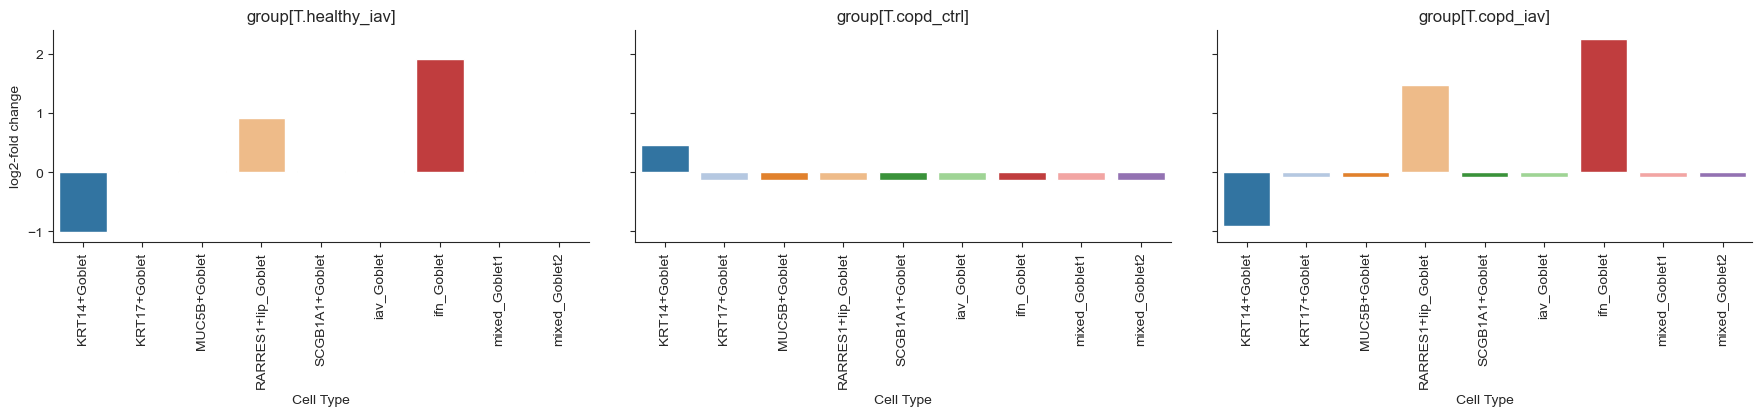

In [ ]:
pt.pl.coda.effects_barplot(sccoda_data, "coda", "group")
plt.show()